In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets ,models, transforms
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.nn import Linear, ReLU, CrossEntropyLoss, Conv2d, MaxPool2d, Module
from torch.optim import Adam
import pandas as pd
import os
from os import listdir
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import torch.optim as optim

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [ ]:
PATH_train='/content/drive/My Drive/pytorch_test'
TRAIN =Path(PATH_train)
batch_size = 32
transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [ ]:
train_data = datasets.ImageFolder(TRAIN, transform=transforms)
train_size = int(0.7 * len(train_data))
valid_size = int(0.2 * len(train_data))
test_size = len(train_data) - (train_size+valid_size)
train_data, valid_data, test_data = torch.utils.data.random_split(train_data, [train_size, valid_size, test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

In [ ]:
def train(model,n_epochs,train_loader,valid_loader,optimizer,criterion):
    train_acc_his,valid_acc_his=[],[]
    train_losses_his,valid_losses_his=[],[]
    for epoch in range(1, n_epochs+1):
        train_loss,valid_loss = 0.0,0.0
        train_losses,valid_losses=[],[]
        train_correct,val_correct,train_total,val_total=0,0,0,0
        train_pred,train_target=torch.zeros(8,1),torch.zeros(8,1)
        val_pred,val_target=torch.zeros(8,1),torch.zeros(8,1)
        count=0
        count2=0
        print('running epoch: {}'.format(epoch))
        model.train()
        for data, target in tqdm(train_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            pred = output.data.max(dim = 1, keepdim = True)[1]
            train_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            train_total += data.size(0)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item()*data.size(0))
            optimizer.zero_grad()
            if count==0:
                train_pred=pred
                train_target=target.data.view_as(pred)
                count=count+1
            else:
                train_pred=torch.cat((train_pred,pred), 0)
                train_target=torch.cat((train_target,target.data.view_as(pred)), 0)
        train_pred=train_pred.cpu().view(-1).numpy().tolist()
        train_target=train_target.cpu().view(-1).numpy().tolist()

        model.eval()
        for data, target in tqdm(valid_loader):
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss =criterion(output, target)
            pred = output.data.max(dim = 1, keepdim = True)[1]
            val_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            val_total += data.size(0)
            valid_losses.append(loss.item()*data.size(0))
            if count2==0:
                val_pred=pred
                val_target=target.data.view_as(pred)
                count2=count+1
            else:
                val_pred=torch.cat((val_pred,pred), 0)
                val_target=torch.cat((val_target,target.data.view_as(pred)), 0)
        val_pred=val_pred.cpu().view(-1).numpy().tolist()
        val_target=val_target.cpu().view(-1).numpy().tolist()
        
        train_loss=np.average(train_losses)
        valid_loss=np.average(valid_losses)
        
        train_acc=train_correct/train_total
        valid_acc=val_correct/val_total
        train_acc_his.append(train_acc)
        valid_acc_his.append(valid_acc)
        train_losses_his.append(train_loss)
        valid_losses_his.append(valid_loss)

        print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(train_loss, valid_loss))
        print('\tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(train_acc, valid_acc))
    return train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model

In [ ]:
def test(model,test_loader,criterion):
    test_acc_his=[]
    test_losses_his=[]
    test_loss = 0.0
    test_losses=[]
    test_correct,test_total=0,0
    test_pred,test_target=torch.zeros(8,1),torch.zeros(8,1)
    count=0
    count2=0
    TP = 0
    FP = 0  
    TN = 0 
    FN = 0
    p = 0 
    r = 0   

    model.eval()
    for data, target in tqdm(test_loader):
      data, target = data.cuda(), target.cuda()
      output = model(data)
      loss =criterion(output, target)
      pred = output.data.max(dim = 1, keepdim = True)[1]
      test_correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
      test_total += data.size(0)
      test_losses.append(loss.item()*data.size(0))
      if count2==0:
          test_pred=pred
          test_target=target.data.view_as(pred)
          count2=count+1
      else:
          test_pred=torch.cat((test_pred,pred), 0)
          test_target=torch.cat((test_target,target.data.view_as(pred)), 0)
      TP += ((pred == 1) & (target.data == 1)).cpu().sum()
      TN += ((pred == 0) & (target.data == 0)).cpu().sum()
      FN += ((pred == 0) & (target.data == 1)).cpu().sum()
      FP += ((pred == 1) & (target.data == 0)).cpu().sum()
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    F1 = 2 * r * p / (r + p)
    test_pred = test_pred.cpu().view(-1).numpy().tolist()
    test_target = test_target.cpu().view(-1).numpy().tolist()
    
    test_loss=np.average(test_losses)
    
    test_acc=test_correct/test_total
    test_acc_his.append(test_acc)
    test_losses_his.append(test_loss)

    print('\tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(test_loss, test_acc))
    print('\tPrecision: {:.6f}'.format(p))
    print('\tRecall: {:.6f}'.format(r))
    print('\tF1: {:.6f}'.format(F1))
    return test_acc_his, test_acc_his, test_losses_his, test_losses_his,model

In [ ]:
model_resnet18 = torch.hub.load('pytorch/vision', 'resnet18', pretrained=True)
for name, param in model_resnet18.named_parameters():
    if("bn" not in name):
        param.requires_grad = False
num_classes = 2
model_resnet18.fc = nn.Sequential(nn.Linear(model_resnet18.fc.in_features,512),nn.ReLU(),nn.Dropout(),nn.Linear(512, num_classes))

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


In [ ]:
n_epochs = 20
model_resnet18.to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.0001, weight_decay=0.05)
train_acc_his,valid_acc_his,train_losses_his,valid_losses_his,model=train(model_resnet18,n_epochs,train_loader,valid_loader,optimizer,criterion)

running epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



	Training Loss: 20.883235 	Validation Loss: 17.870896
	Training Accuracy: 0.613304 	Validation Accuracy: 0.716113
running epoch: 2



	Training Loss: 17.144533 	Validation Loss: 15.303794
	Training Accuracy: 0.751462 	Validation Accuracy: 0.749361
running epoch: 3



	Training Loss: 15.502334 	Validation Loss: 13.013415
	Training Accuracy: 0.777047 	Validation Accuracy: 0.823529
running epoch: 4



	Training Loss: 13.622834 	Validation Loss: 12.218677
	Training Accuracy: 0.809942 	Validation Accuracy: 0.831202
running epoch: 5



	Training Loss: 13.073379 	Validation Loss: 11.725608
	Training Accuracy: 0.823830 	Validation Accuracy: 0.826087
running epoch: 6



	Training Loss: 12.109022 	Validation Loss: 11.053695
	Training Accuracy: 0.836257 	Validation Accuracy: 0.838875
running epoch: 7



	Training Loss: 11.852990 	Validation Loss: 11.784413
	Training Accuracy: 0.844298 	Validation Accuracy: 0.813299
running epoch: 8



	Training Loss: 11.129004 	Validation Loss: 10.829195
	Training Accuracy: 0.847222 	Validation Accuracy: 0.831202
running epoch: 9



	Training Loss: 10.890575 	Validation Loss: 10.501970
	Training Accuracy: 0.857456 	Validation Accuracy: 0.841432
running epoch: 10



	Training Loss: 10.101647 	Validation Loss: 10.401136
	Training Accuracy: 0.873538 	Validation Accuracy: 0.823529
running epoch: 11



	Training Loss: 9.680261 	Validation Loss: 10.348643
	Training Accuracy: 0.874269 	Validation Accuracy: 0.831202
running epoch: 12



	Training Loss: 9.706760 	Validation Loss: 10.377929
	Training Accuracy: 0.864766 	Validation Accuracy: 0.831202
running epoch: 13



	Training Loss: 9.548937 	Validation Loss: 10.375525
	Training Accuracy: 0.880848 	Validation Accuracy: 0.861893
running epoch: 14



	Training Loss: 9.051500 	Validation Loss: 10.452028
	Training Accuracy: 0.888158 	Validation Accuracy: 0.831202
running epoch: 15



	Training Loss: 9.076335 	Validation Loss: 9.754365
	Training Accuracy: 0.882310 	Validation Accuracy: 0.849105
running epoch: 16



	Training Loss: 8.512556 	Validation Loss: 9.810190
	Training Accuracy: 0.894006 	Validation Accuracy: 0.849105
running epoch: 17



	Training Loss: 8.025636 	Validation Loss: 10.340346
	Training Accuracy: 0.902778 	Validation Accuracy: 0.836317
running epoch: 18



	Training Loss: 8.971226 	Validation Loss: 9.976451
	Training Accuracy: 0.880848 	Validation Accuracy: 0.864450
running epoch: 19



	Training Loss: 7.856142 	Validation Loss: 9.669199
	Training Accuracy: 0.905702 	Validation Accuracy: 0.851662
running epoch: 20



	Training Loss: 8.497867 	Validation Loss: 9.691548
	Training Accuracy: 0.895468 	Validation Accuracy: 0.851662


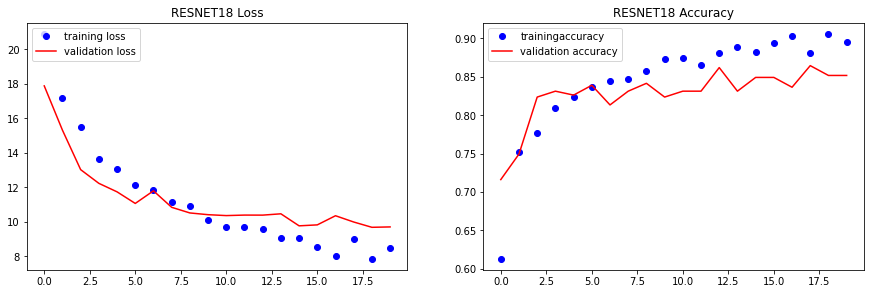

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his, 'bo', label = 'training loss')
plt.plot(valid_losses_his, 'r', label = 'validation loss')
plt.title("RESNET18 Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his, 'bo', label = 'trainingaccuracy')
plt.plot(valid_acc_his, 'r', label = 'validation accuracy')
plt.title("RESNET18 Accuracy")
plt.legend(loc='upper left')
plt.show()

In [ ]:
test_acc_his,test_acc_his,test_losses_his,test_losses_his,model1=test(model_resnet18,test_loader,criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



	Test Loss: 9.691548 	Test Accuracy: 0.851662
	Precision: 0.515292
	Recall: 0.552395
	F1: 0.533199


In [ ]:
model_resnet34 = torch.hub.load('pytorch/vision', 'resnet34', pretrained=True)
for name, param in model_resnet34.named_parameters():
    if("bn" not in name):
        param.requires_grad = False
model_resnet34.fc = nn.Sequential(nn.Linear(model_resnet34.fc.in_features,512),nn.ReLU(),nn.Dropout(),nn.Linear(512, num_classes))

In [ ]:
n_epochs = 20
model_resnet34.to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model_resnet34.parameters(), lr=0.0001, weight_decay=0.05)
train_acc_his34,valid_acc_his34,train_losses_his34,valid_losses_his34,model34=train(model_resnet34,n_epochs,train_loader,valid_loader,optimizer,criterion)

running epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



	Training Loss: 20.907916 	Validation Loss: 17.881954
	Training Accuracy: 0.608918 	Validation Accuracy: 0.708440
running epoch: 2



	Training Loss: 17.687413 	Validation Loss: 15.114522
	Training Accuracy: 0.744883 	Validation Accuracy: 0.780051
running epoch: 3



	Training Loss: 15.285527 	Validation Loss: 13.361584
	Training Accuracy: 0.779240 	Validation Accuracy: 0.836317
running epoch: 4



	Training Loss: 13.895446 	Validation Loss: 12.488495
	Training Accuracy: 0.805556 	Validation Accuracy: 0.828645
running epoch: 5



	Training Loss: 12.304223 	Validation Loss: 12.217565
	Training Accuracy: 0.847222 	Validation Accuracy: 0.813299
running epoch: 6



	Training Loss: 12.159490 	Validation Loss: 11.272590
	Training Accuracy: 0.836988 	Validation Accuracy: 0.856777
running epoch: 7



	Training Loss: 11.410691 	Validation Loss: 11.226170
	Training Accuracy: 0.855263 	Validation Accuracy: 0.846547
running epoch: 8



	Training Loss: 10.111161 	Validation Loss: 11.002221
	Training Accuracy: 0.873538 	Validation Accuracy: 0.854220
running epoch: 9



	Training Loss: 9.913050 	Validation Loss: 10.671445
	Training Accuracy: 0.871345 	Validation Accuracy: 0.861893
running epoch: 10



	Training Loss: 9.717034 	Validation Loss: 11.063920
	Training Accuracy: 0.880848 	Validation Accuracy: 0.838875
running epoch: 11



	Training Loss: 9.195597 	Validation Loss: 10.311968
	Training Accuracy: 0.886696 	Validation Accuracy: 0.869565
running epoch: 12



	Training Loss: 8.311246 	Validation Loss: 10.695633
	Training Accuracy: 0.896199 	Validation Accuracy: 0.851662
running epoch: 13



	Training Loss: 7.731805 	Validation Loss: 10.199286
	Training Accuracy: 0.904240 	Validation Accuracy: 0.854220
running epoch: 14



	Training Loss: 7.733243 	Validation Loss: 9.986923
	Training Accuracy: 0.904240 	Validation Accuracy: 0.869565
running epoch: 15



	Training Loss: 7.461149 	Validation Loss: 9.964453
	Training Accuracy: 0.903509 	Validation Accuracy: 0.869565
running epoch: 16



	Training Loss: 6.955974 	Validation Loss: 10.164913
	Training Accuracy: 0.920322 	Validation Accuracy: 0.879795
running epoch: 17



	Training Loss: 7.166810 	Validation Loss: 9.868936
	Training Accuracy: 0.915936 	Validation Accuracy: 0.879795
running epoch: 18



	Training Loss: 6.001454 	Validation Loss: 9.499636
	Training Accuracy: 0.926170 	Validation Accuracy: 0.882353
running epoch: 19



	Training Loss: 6.477745 	Validation Loss: 9.661391
	Training Accuracy: 0.926901 	Validation Accuracy: 0.879795
running epoch: 20



	Training Loss: 5.815030 	Validation Loss: 10.055239
	Training Accuracy: 0.935673 	Validation Accuracy: 0.856777


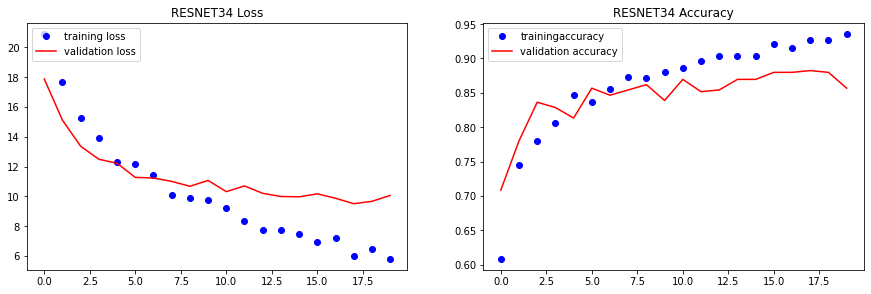

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his34, 'bo', label = 'training loss')
plt.plot(valid_losses_his34, 'r', label = 'validation loss')
plt.title("RESNET34 Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his34, 'bo', label = 'trainingaccuracy')
plt.plot(valid_acc_his34, 'r', label = 'validation accuracy')
plt.title("RESNET34 Accuracy")
plt.legend(loc='upper left')
plt.show()

In [ ]:
test_acc_his,test_acc_his,test_losses_his,test_losses_his,model1=test(model_resnet34,test_loader,criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



	Test Loss: 10.055236 	Test Accuracy: 0.856777
	Precision: 0.510916
	Recall: 0.579235
	F1: 0.542935


In [ ]:
model_resnet50 = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)
for name, param in model_resnet50.named_parameters():
    if("bn" not in name):
        param.requires_grad = False
model_resnet50.fc = nn.Sequential(nn.Linear(model_resnet50.fc.in_features,512),nn.ReLU(),nn.Dropout(),nn.Linear(512, num_classes))

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


In [ ]:
n_epochs = 20
model_resnet50.to(device)
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=0.0001, weight_decay=0.05)
train_acc_his50,valid_acc_his50,train_losses_his50,valid_losses_his50,model50=train(model_resnet50,n_epochs,train_loader,valid_loader,optimizer,criterion)

running epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



	Training Loss: 22.311738 	Validation Loss: 20.491394
	Training Accuracy: 0.486842 	Validation Accuracy: 0.578005
running epoch: 2



	Training Loss: 22.245562 	Validation Loss: 20.731966
	Training Accuracy: 0.505117 	Validation Accuracy: 0.524297
running epoch: 3



	Training Loss: 22.452231 	Validation Loss: 20.756193
	Training Accuracy: 0.457602 	Validation Accuracy: 0.514066
running epoch: 4



	Training Loss: 22.399574 	Validation Loss: 20.819804
	Training Accuracy: 0.470029 	Validation Accuracy: 0.516624
running epoch: 5



	Training Loss: 22.375573 	Validation Loss: 20.807631
	Training Accuracy: 0.479532 	Validation Accuracy: 0.516624
running epoch: 6



	Training Loss: 22.257997 	Validation Loss: 20.811453
	Training Accuracy: 0.487573 	Validation Accuracy: 0.511509
running epoch: 7



	Training Loss: 22.414630 	Validation Loss: 20.785293
	Training Accuracy: 0.486842 	Validation Accuracy: 0.519182
running epoch: 8



	Training Loss: 22.206512 	Validation Loss: 20.791599
	Training Accuracy: 0.500000 	Validation Accuracy: 0.526854
running epoch: 9



	Training Loss: 22.281031 	Validation Loss: 20.836436
	Training Accuracy: 0.505848 	Validation Accuracy: 0.498721
running epoch: 10



	Training Loss: 22.230385 	Validation Loss: 20.799748
	Training Accuracy: 0.496345 	Validation Accuracy: 0.511509
running epoch: 11



	Training Loss: 22.366518 	Validation Loss: 20.812643
	Training Accuracy: 0.480994 	Validation Accuracy: 0.503836
running epoch: 12



	Training Loss: 22.308619 	Validation Loss: 20.794078
	Training Accuracy: 0.488304 	Validation Accuracy: 0.506394
running epoch: 13



	Training Loss: 22.347603 	Validation Loss: 20.822703
	Training Accuracy: 0.489766 	Validation Accuracy: 0.501279
running epoch: 14



	Training Loss: 22.161079 	Validation Loss: 20.772800
	Training Accuracy: 0.522661 	Validation Accuracy: 0.531969
running epoch: 15



	Training Loss: 22.590115 	Validation Loss: 20.781234
	Training Accuracy: 0.477339 	Validation Accuracy: 0.526854
running epoch: 16



	Training Loss: 22.222842 	Validation Loss: 20.776538
	Training Accuracy: 0.503655 	Validation Accuracy: 0.534527
running epoch: 17



	Training Loss: 22.287362 	Validation Loss: 20.827358
	Training Accuracy: 0.489766 	Validation Accuracy: 0.501279
running epoch: 18



	Training Loss: 22.395009 	Validation Loss: 20.746961
	Training Accuracy: 0.475877 	Validation Accuracy: 0.524297
running epoch: 19



	Training Loss: 22.346769 	Validation Loss: 20.800576
	Training Accuracy: 0.482456 	Validation Accuracy: 0.501279
running epoch: 20



	Training Loss: 22.206059 	Validation Loss: 20.760107
	Training Accuracy: 0.494883 	Validation Accuracy: 0.534527


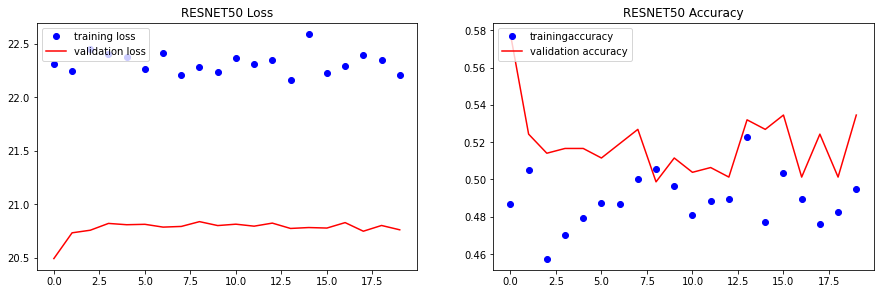

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(train_losses_his50, 'bo', label = 'training loss')
plt.plot(valid_losses_his50, 'r', label = 'validation loss')
plt.title("RESNET50 Loss")
plt.legend(loc='upper left')
plt.subplot(222)
plt.plot(train_acc_his50, 'bo', label = 'trainingaccuracy')
plt.plot(valid_acc_his50, 'r', label = 'validation accuracy')
plt.title("RESNET50 Accuracy")
plt.legend(loc='upper left')
plt.show()